In [1]:
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [20]:
class Agent:
    
    def __init__(self, nA=2, alpha=0.05, gamma=1.0, epsilon=1.0, epsilon_decay=.9999, epsilon_min=.05):
        self.nA = nA
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.Q = defaultdict(lambda: np.zeros(nA))

    def select_action(self, state):
        probabilities = np.ones(self.nA) * self.epsilon / self.nA
        greedy_action = np.argmax(self.Q)
        probabilities[greedy_action] = 1- self.epsilon + (self.epsilon/self.nA)
        action = np.random.choice(np.arange(self.nA), p=probabilities)
        return action
    
    def update_q(self, state, action, reward, next_state, next_action):
        next_action = self.select_action(next_state)
        prev_q = self.Q[state][action]
        self.Q[state][action] = (1-self.alpha)*prev_q + self.alpha*(reward+self.gamma*np.max(self.Q[next_state]))
        
    def update_mc(self, states, actions, rewards):
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            previous_Q = self.Q[state][actions[i]]
            self.Q[state][actions[i]] = previous_Q + self.alpha*(sum(rewards[i:]*discounts[:-(1+i)])-previous_Q)

In [5]:
def interact_mc(env, agent, num_episodes, window=100):
    won = 0
    lost = 0
    draws = 0
    
    for i_episode in range(1, num_episodes+1):
        ep_states, ep_actions, ep_rewards = [], [], []
        state = env.reset()
        while True:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            ep_states.append(state)
            ep_actions.append(action)
            ep_rewards.append(reward)
            state = next_state
            
            if done:
                agent.update_mc(ep_states, ep_actions,ep_rewards)
                if sum(ep_rewards) >=1:
                    won +=1
                elif sum(ep_rewards) < 0:
                    lost += 1
                elif sum(ep_rewards) == 0:
                    draws += 1
                break
                
        if i_episode % window ==0:
            print('Episode {}|| won {}, drew {}, lost {} of games.'.format(i_episode, won, draws, lost))
            won = 0
            lost = 0
            draws = 0
            
    return agent.Q

In [21]:
agent = Agent()
Q_table = interact_mc(env, agent, num_episodes=100000)

Episode 100|| won 25, drew 8, lost 67 of games.
Episode 200|| won 26, drew 3, lost 71 of games.
Episode 300|| won 26, drew 3, lost 71 of games.
Episode 400|| won 32, drew 4, lost 64 of games.
Episode 500|| won 20, drew 3, lost 77 of games.
Episode 600|| won 30, drew 1, lost 69 of games.
Episode 700|| won 23, drew 9, lost 68 of games.
Episode 800|| won 31, drew 7, lost 62 of games.
Episode 900|| won 29, drew 4, lost 67 of games.
Episode 1000|| won 36, drew 6, lost 58 of games.
Episode 1100|| won 36, drew 3, lost 61 of games.
Episode 1200|| won 27, drew 5, lost 68 of games.
Episode 1300|| won 30, drew 2, lost 68 of games.
Episode 1400|| won 23, drew 10, lost 67 of games.
Episode 1500|| won 28, drew 4, lost 68 of games.
Episode 1600|| won 25, drew 11, lost 64 of games.
Episode 1700|| won 26, drew 4, lost 70 of games.
Episode 1800|| won 35, drew 4, lost 61 of games.
Episode 1900|| won 29, drew 6, lost 65 of games.
Episode 2000|| won 31, drew 9, lost 60 of games.
Episode 2100|| won 32, drew

Episode 18800|| won 28, drew 3, lost 69 of games.
Episode 18900|| won 39, drew 4, lost 57 of games.
Episode 19000|| won 28, drew 7, lost 65 of games.
Episode 19100|| won 22, drew 7, lost 71 of games.
Episode 19200|| won 31, drew 1, lost 68 of games.
Episode 19300|| won 29, drew 0, lost 71 of games.
Episode 19400|| won 30, drew 5, lost 65 of games.
Episode 19500|| won 33, drew 11, lost 56 of games.
Episode 19600|| won 25, drew 2, lost 73 of games.
Episode 19700|| won 22, drew 5, lost 73 of games.
Episode 19800|| won 28, drew 5, lost 67 of games.
Episode 19900|| won 32, drew 5, lost 63 of games.
Episode 20000|| won 32, drew 7, lost 61 of games.
Episode 20100|| won 26, drew 6, lost 68 of games.
Episode 20200|| won 23, drew 4, lost 73 of games.
Episode 20300|| won 23, drew 2, lost 75 of games.
Episode 20400|| won 35, drew 3, lost 62 of games.
Episode 20500|| won 24, drew 4, lost 72 of games.
Episode 20600|| won 26, drew 6, lost 68 of games.
Episode 20700|| won 23, drew 3, lost 74 of games.

Episode 35300|| won 24, drew 6, lost 70 of games.
Episode 35400|| won 27, drew 5, lost 68 of games.
Episode 35500|| won 28, drew 4, lost 68 of games.
Episode 35600|| won 32, drew 4, lost 64 of games.
Episode 35700|| won 25, drew 1, lost 74 of games.
Episode 35800|| won 22, drew 0, lost 78 of games.
Episode 35900|| won 26, drew 4, lost 70 of games.
Episode 36000|| won 30, drew 5, lost 65 of games.
Episode 36100|| won 22, drew 4, lost 74 of games.
Episode 36200|| won 14, drew 7, lost 79 of games.
Episode 36300|| won 28, drew 2, lost 70 of games.
Episode 36400|| won 32, drew 8, lost 60 of games.
Episode 36500|| won 28, drew 5, lost 67 of games.
Episode 36600|| won 32, drew 4, lost 64 of games.
Episode 36700|| won 35, drew 3, lost 62 of games.
Episode 36800|| won 22, drew 3, lost 75 of games.
Episode 36900|| won 27, drew 6, lost 67 of games.
Episode 37000|| won 26, drew 7, lost 67 of games.
Episode 37100|| won 23, drew 5, lost 72 of games.
Episode 37200|| won 33, drew 3, lost 64 of games.


Episode 51900|| won 29, drew 3, lost 68 of games.
Episode 52000|| won 22, drew 8, lost 70 of games.
Episode 52100|| won 21, drew 5, lost 74 of games.
Episode 52200|| won 24, drew 4, lost 72 of games.
Episode 52300|| won 25, drew 3, lost 72 of games.
Episode 52400|| won 25, drew 4, lost 71 of games.
Episode 52500|| won 32, drew 3, lost 65 of games.
Episode 52600|| won 28, drew 8, lost 64 of games.
Episode 52700|| won 31, drew 7, lost 62 of games.
Episode 52800|| won 31, drew 1, lost 68 of games.
Episode 52900|| won 31, drew 4, lost 65 of games.
Episode 53000|| won 27, drew 3, lost 70 of games.
Episode 53100|| won 23, drew 4, lost 73 of games.
Episode 53200|| won 30, drew 9, lost 61 of games.
Episode 53300|| won 29, drew 4, lost 67 of games.
Episode 53400|| won 31, drew 7, lost 62 of games.
Episode 53500|| won 28, drew 5, lost 67 of games.
Episode 53600|| won 26, drew 4, lost 70 of games.
Episode 53700|| won 30, drew 6, lost 64 of games.
Episode 53800|| won 32, drew 2, lost 66 of games.


Episode 68700|| won 26, drew 5, lost 69 of games.
Episode 68800|| won 21, drew 3, lost 76 of games.
Episode 68900|| won 27, drew 5, lost 68 of games.
Episode 69000|| won 33, drew 3, lost 64 of games.
Episode 69100|| won 27, drew 8, lost 65 of games.
Episode 69200|| won 30, drew 1, lost 69 of games.
Episode 69300|| won 26, drew 6, lost 68 of games.
Episode 69400|| won 24, drew 5, lost 71 of games.
Episode 69500|| won 29, drew 7, lost 64 of games.
Episode 69600|| won 42, drew 3, lost 55 of games.
Episode 69700|| won 31, drew 2, lost 67 of games.
Episode 69800|| won 36, drew 5, lost 59 of games.
Episode 69900|| won 26, drew 5, lost 69 of games.
Episode 70000|| won 28, drew 7, lost 65 of games.
Episode 70100|| won 25, drew 10, lost 65 of games.
Episode 70200|| won 32, drew 5, lost 63 of games.
Episode 70300|| won 24, drew 9, lost 67 of games.
Episode 70400|| won 34, drew 1, lost 65 of games.
Episode 70500|| won 17, drew 4, lost 79 of games.
Episode 70600|| won 21, drew 3, lost 76 of games.

Episode 85200|| won 18, drew 5, lost 77 of games.
Episode 85300|| won 30, drew 5, lost 65 of games.
Episode 85400|| won 25, drew 4, lost 71 of games.
Episode 85500|| won 25, drew 5, lost 70 of games.
Episode 85600|| won 34, drew 4, lost 62 of games.
Episode 85700|| won 27, drew 4, lost 69 of games.
Episode 85800|| won 34, drew 3, lost 63 of games.
Episode 85900|| won 26, drew 3, lost 71 of games.
Episode 86000|| won 28, drew 9, lost 63 of games.
Episode 86100|| won 25, drew 2, lost 73 of games.
Episode 86200|| won 25, drew 2, lost 73 of games.
Episode 86300|| won 29, drew 8, lost 63 of games.
Episode 86400|| won 24, drew 8, lost 68 of games.
Episode 86500|| won 22, drew 3, lost 75 of games.
Episode 86600|| won 43, drew 5, lost 52 of games.
Episode 86700|| won 24, drew 3, lost 73 of games.
Episode 86800|| won 25, drew 5, lost 70 of games.
Episode 86900|| won 31, drew 5, lost 64 of games.
Episode 87000|| won 27, drew 4, lost 69 of games.
Episode 87100|| won 27, drew 6, lost 67 of games.


In [9]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

In [22]:
policy = dict((k,np.argmax(v)) for k, v in agent.Q.items())
V = dict((k,np.max(v)) for k, v in Q_table.items())

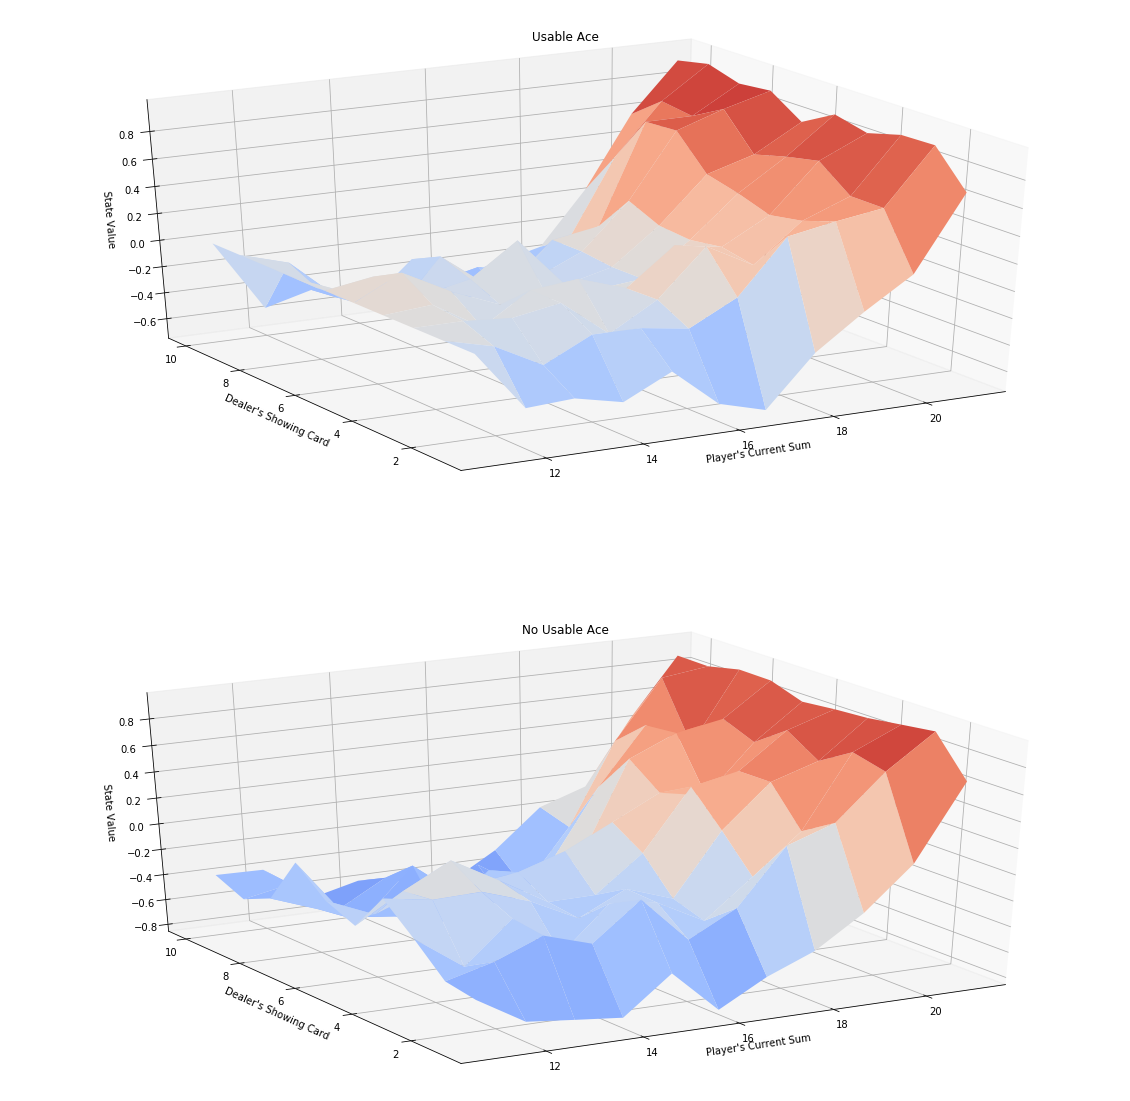

In [23]:
plot_blackjack_values(V)

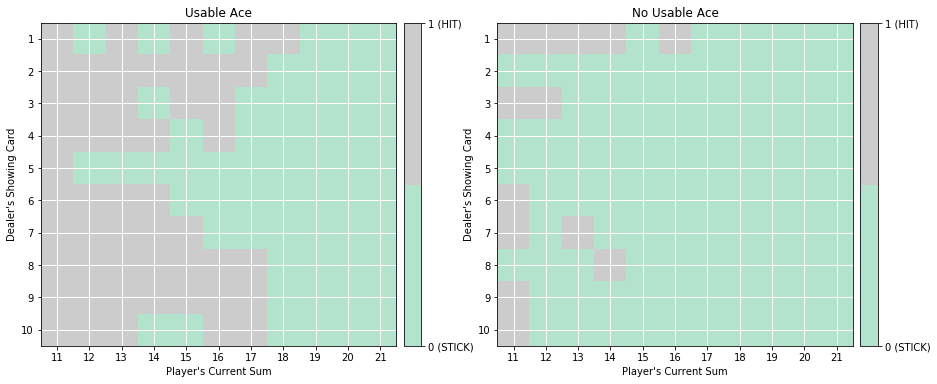

In [24]:
plot_policy(policy)